# 1. Import and Install Dependencies

In [1]:
# Nếu chưa có thư viện thì run cell này
!pip install mediapipe
!pip install pandas
!pip install numpy
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 15.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from PIL import Image, ImageOps
import traceback
import time

# 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # Show to screen
#         cv2.imshow('OpenCV Feed', image)

#         # Break gracefully
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

# 3. Setup Folders for Collection

In [3]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('./Data')
DATA_PATH = os.path.join('./drive/MyDrive/PBL5/Data/')

# Actions that we try to detect
actions = np.array(
[
    "Bye",
    "Eat",
    "Fine",
    "Good",
    "Hello",
    "I",
    "You",
    "Love",
    "None",
    "Read",
    "What",
    "Name",
    "Sleep",
    "Your"
  ]
    )

# Path for exported data, numpy arrays
# DATASET_PATH = os.path.join('./Data')



In [4]:
len(set(actions))

14

# 4. Extract Keypoint Values

In [67]:
import subprocess
list_num_frames  = []

for class_index, class_name in enumerate(actions):
    files_list = os.listdir(os.path.join(DATA_PATH, class_name))
    # Iterate through all the files present in the files list.
    for file_name in files_list:
        # print(file_name)
        # Get the complete video path.
        video_file_path = os.path.join(
            DATA_PATH, class_name, file_name)
        c = 'ffmpeg -y -i ' + video_file_path + ' -r 20 -c:v libx264 -preset ultrafast -movflags +faststart ' + video_file_path
        subprocess.call(c, shell=True)
        cap = cv2.VideoCapture(video_file_path)
        num_frames = 0
        while True:
            num_frames += 1
            rt, f = cap.read()
            if not rt:
                break
        list_num_frames.append(num_frames)
        cap.release()


Text(0.5, 1.0, 'SỐ LƯỢNG FRAME MỖI HÀNH ĐỘNG')

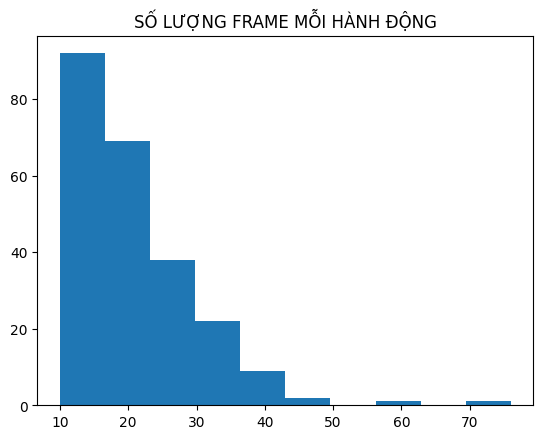

In [68]:
a = plt.hist(list_num_frames)
plt.title('SỐ LƯỢNG FRAME MỖI HÀNH ĐỘNG')

In [69]:
sum(np.array(list_num_frames) > 12)

216

In [70]:
sequence_length = 12

In [71]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*4)
    return np.concatenate([pose, lh, rh])

In [72]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [73]:
def resize_with_padding(img, expected_size):
    img = Image.fromarray(img)
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return np.array(ImageOps.expand(img, padding))

In [74]:
def frames_extraction(video_path, rev=False, angle=0, padding=False):
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = 0
    s, f = video_reader.read()
    while s:
        s, f = video_reader.read()
        video_frames_count += 1
    video_reader.release()

    if video_frames_count < sequence_length:
        return []
    skip_frames = int(0.1 * video_frames_count)
    skip_frames_window = max(int((video_frames_count - skip_frames*2) /sequence_length), 1)

    # Danh sách chứa các frame sẽ lấy
    video_keypoints = []

    cap = cv2.VideoCapture(video_path)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame_counter in range(sequence_length):
            cap.set(cv2.CAP_PROP_POS_FRAMES,
                    skip_frames + frame_counter * skip_frames_window)
            
            ret, frame = cap.read()
            if not ret:
                print('eror')
                continue

            if rev:
                frame = cv2.flip(frame, 1)
            if angle:
                frame = rotate_image(frame, angle=angle)
            if padding: 
                padding = np.random.randint(12, 17) / 10
                frame = resize_with_padding(frame, (int(frame.shape[1] * padding),int(frame.shape[0] * padding)))

            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)   

            keypoints = extract_keypoints(results)
            video_keypoints.append(keypoints)

    return video_keypoints


# 5. Collect Keypoint Values for Training and Testing

In [83]:
features = []
labels = []
def dataOneFile(video_file_path, class_index, padding=False):
    global features
    global labels
    video_keypoints = frames_extraction(video_file_path, padding=padding)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)

    # flip 
    video_keypoints = frames_extraction(video_file_path,  padding=padding, rev=True)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)
    # random rotate
    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(10, 30), padding=padding, rev=True)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)
    
    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(-30, -10), padding=padding, rev=True)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)

    video_keypoints = frames_extraction(video_file_path, padding=padding, rev=False)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)
    # random rotate
    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(10, 30), padding=padding, rev=False)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)
    
    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(-30, -10), padding=padding, rev=False)
    if len(video_keypoints) == sequence_length:
        features.append(video_keypoints)
        labels.append(class_index)

In [84]:
def create_dataset():
    for class_index, class_name in enumerate(actions):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATA_PATH, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # print(file_name)
            try:
                video_file_path = os.path.join(
                    DATA_PATH, class_name, file_name)
                dataOneFile(video_file_path, class_index)
                dataOneFile(video_file_path, class_index, True)
                
            except Exception as e:
                print(e)
                traceback.print_stack()
                continue

        cv2.destroyAllWindows()
    return features, labels

In [85]:
time_start = time.time()
create_dataset()
features = np.asarray(features)
labels = np.array(labels)
np.savez_compressed(f'{DATA_PATH}/data_rich_full_padding1.npz', features=features, labels=labels)
time_end = time.time()
print('total time: ', time_end - time_start)

Extracting Data of Class: Bye
video37428.avi
video191327.avi
video482995.avi
video196846.avi
video143362.avi
video120227.avi
video720597.avi
video340613.avi
video418613.avi
video178054.avi
video128510.avi
video365760.avi
video466794.avi
video110828.avi
video283759.avi
video97025.avi
video143212.avi
video715320.avi
video163353.avi
video136007.avi
video96991.avi
video317003.avi
video67374.avi
video694331.avi
video77719.avi
video43395.avi
video150143.avi
video207212.avi
video516601.avi
video487758.avi
video86084.avi
video58000.avi
video169287.avi
video522035.avi
video511943.avi
video128989.avi
video701151.avi
video104198.avi
video50642.avi
video370956.avi
Extracting Data of Class: Eat
video294505.avi
257.avi
114.avi
115.avi
video86326.avi
video56012.avi
video70500.avi
video156789.avi
video292522.avi
video204388.avi
video173689.avi
256.avi
009.avi
video226738.avi
007.avi
video204628.avi
video90924.avi
video304945.avi
video282980.avi
008.avi
253.avi
261.avi
262.avi
110.avi
106.avi
video3053

In [9]:
data1 = np.load(f'{DATA_PATH}data_rich_full_padding1.npz')
X1 = data1['features']
labels1 = data1['labels']
set(labels1)

{0, 1, 2, 3, 4}

In [10]:
data2 = np.load(f'{DATA_PATH}data_rich_full_padding2.npz')
X2 = data2['features']
labels2 = data2['labels']
set(labels2)

{5, 6, 7, 8, 9}

In [11]:
data3 = np.load(f'{DATA_PATH}data_rich_full_padding3.npz')
X3 = data3['features']
labels3 = data3['labels'] 
set(labels3)

{10, 11, 12, 13}

In [ ]:
x10 = X3[labels==10]
labels10 = labels3[labels3==10]
x10 = x10[:658]
labels10 = labels10[:658]
X3 = np.concatenate([X3, x10])
labels3 = np.concatenate([labels3, labels10])


In [12]:
X = np.concatenate([X1, X2, X3])
X.shape

(10220, 10, 300)

In [13]:
labels = np.concatenate([labels1, labels2, labels3])
labels.shape

(10220,)

In [46]:
np.savez_compressed(f'{DATA_PATH}/data_rich_full_padding.npz', features=X, labels=labels)

# 6. Preprocess Data and Create Labels and Features

In [1]:
# Nếu chưa có thư viện thì run cell này
!pip install mediapipe
!pip install pandas
!pip install numpy
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 58.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [4]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('./Data')
DATA_PATH = os.path.join('./drive/MyDrive/PBL5/Data/')
log_dir = os.path.join(f'./drive/MyDrive/PBL5/Data/Logs/{time.time()}')
checkpoint_filepath = f'./drive/MyDrive/PBL5/Data/checkpoint/{time.time()}'


# Actions that we try to detect
actions = np.array(
['Bye','Eat', 'Fine', 'Good', 'Hello', 'I', 'You', 'Love', 'None', 'Read', 'What', 'Name', 'Sleep', 'Your']
    )
sequence_length = 12
# Path for exported data, numpy arrays
# DATASET_PATH = os.path.join('./Data')
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Bye': 0,
 'Eat': 1,
 'Fine': 2,
 'Good': 3,
 'Hello': 4,
 'I': 5,
 'You': 6,
 'Love': 7,
 'None': 8,
 'Read': 9,
 'What': 10,
 'Name': 11,
 'Sleep': 12,
 'Your': 13}

In [5]:
data = np.load(f'{DATA_PATH}/data_rich_full_padding.npz')
X = data['features']
labels = data['labels']

In [6]:
X.shape

(9534, 10, 300)

In [7]:
y = to_categorical(labels).astype(int)

In [8]:
y.shape

(9534, 14)

In [9]:
for i in set(labels):
  print(i, len(y[labels==i]))

0 560
1 770
2 546
3 700
4 658
5 742
6 742
7 784
8 728
9 644
10 658
11 616
12 700
13 686


(array([112., 154., 109., 140., 132., 148., 148., 157., 146., 129., 132.,
        123., 140., 137.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 <BarContainer object of 14 artists>)

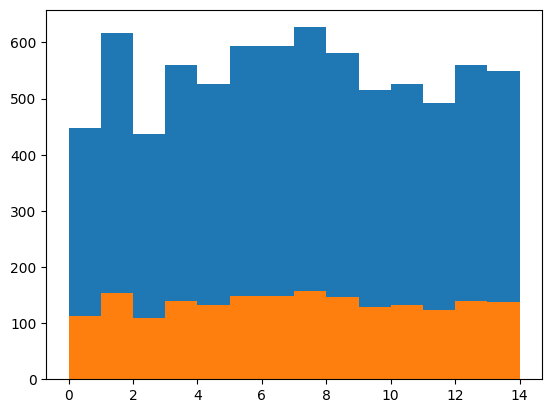

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for splitting
train_idx, test_idx = next(splitter.split(X, y))

# Split the data into train and test sets
X_train_val = X[train_idx]
X_test = X[test_idx]
y_train_val = y[train_idx]
y_test = y[test_idx]
plt.hist(np.argmax(y_train_val, 1), bins=np.arange(0,15), label=label_map)
plt.hist(np.argmax(y_test, 1), bins=np.arange(0,15), label=label_map)

(array([ 90., 123.,  87., 112., 105., 119., 119., 126., 116., 103., 105.,
         99., 112., 110.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 <BarContainer object of 14 artists>)

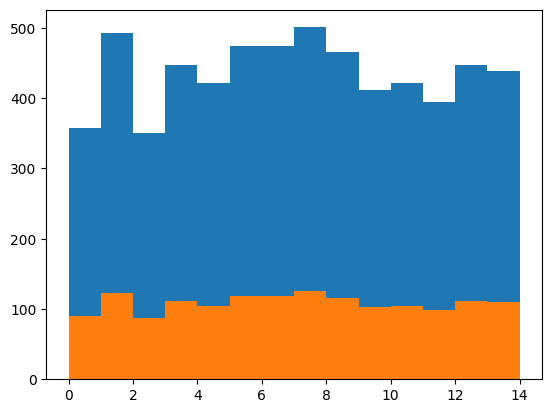

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for splitting
train_idx, val_idx = next(splitter2.split(X_train_val, y_train_val))

# Split the data into train and val sets
X_train = X_train_val[train_idx]
X_val = X_train_val[val_idx]
y_train = y_train_val[train_idx]
y_val = y_train_val[val_idx]
plt.hist(np.argmax(y_train, 1), bins=range(0,15), label=label_map)
plt.hist(np.argmax(y_val, 1), bins=range(0,15), label=label_map)

# 7. Build and Train LSTM Neural Network

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import initializers
import tensorflow as tf
import time

In [25]:
# set Glorot initialization for all layers

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu',
     kernel_initializer= initializers.he_normal(), 
     input_shape=(sequence_length,X.shape[-1])))
model.add(LSTM(128, return_sequences=True, activation='relu',
     kernel_initializer= initializers.he_normal()))
model.add(LSTM(64, return_sequences=False, activation='relu',
     kernel_initializer= initializers.he_normal()))
model.add(Dense(64, activation='relu',
     kernel_initializer= initializers.he_normal()))
model.add(Dense(32, activation='relu',
     kernel_initializer= initializers.he_normal()))
model.add(Dense(actions.shape[0], activation='softmax',
     kernel_initializer= initializers.he_normal()))

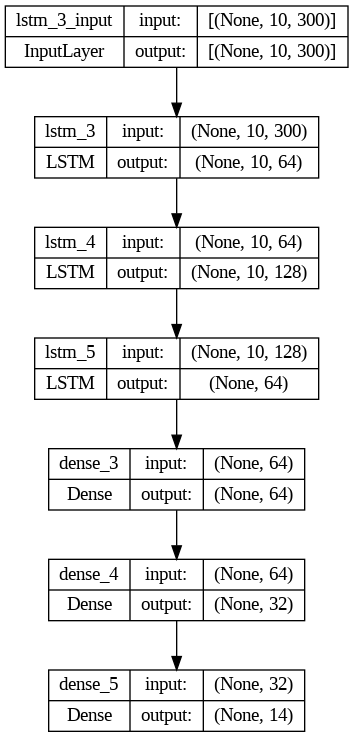

In [20]:
from keras.utils import plot_model

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 64)            93440     
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 14)                462       
                                                                 
Total params: 248,366
Trainable params: 248,366
Non-tr

In [22]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

In [26]:
time_start = time.time()
learning_rate = 0.001
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr / 10
    return lr

# Create a callback to use the scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=Adam(learning_rate=learning_rate, ), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


epoch = 300
batch_size = 2
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping_callback_acc = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

# model = tf.keras.models.load_model(path_weight)
model_history = model.fit(x = X_train, y = y_train, epochs = epoch, shuffle = True, validation_data=[X_val, y_val], batch_size=batch_size, callbacks = [early_stopping_callback_acc, tb_callback, model_checkpoint_callback, lr_scheduler])

path_weight =f'{DATA_PATH}/weight_rich_padding_bs{batch_size}_lr{learning_rate}.h5'
model.save(path_weight)
time_end = time.time()
print(f'total time: {(time_start-time_end)/60}h')

Epoch 1/300
3048/3051 [============================>.] - ETA: 0s - loss: 1.6720 - categorical_accuracy: 0.4281

3051/3051 [==============================] - 66s 20ms/step - loss: 1.6719 - categorical_accuracy: 0.4280 - val_loss: 1.3215 - val_categorical_accuracy: 0.5151 - lr: 0.0010
Epoch 2/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.9236 - categorical_accuracy: 0.6718

3051/3051 [==============================] - 61s 20ms/step - loss: 0.9236 - categorical_accuracy: 0.6719 - val_loss: 1.0164 - val_categorical_accuracy: 0.6488 - lr: 0.0010
Epoch 3/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.6911 - categorical_accuracy: 0.7635

3051/3051 [==============================] - 64s 21ms/step - loss: 0.6908 - categorical_accuracy: 0.7636 - val_loss: 0.6613 - val_categorical_accuracy: 0.8342 - lr: 0.0010
Epoch 4/300
3048/3051 [============================>.] - ETA: 0s - loss: 0.6158 - categorical_accuracy: 0.7925

3051/3051 [==============================] - 61s 20ms/step - loss: 0.6154 - categorical_accuracy: 0.7927 - val_loss: 0.7012 - val_categorical_accuracy: 0.7516 - lr: 0.0010
Epoch 5/300
3048/3051 [============================>.] - ETA: 0s - loss: 0.5227 - categorical_accuracy: 0.8250

3051/3051 [==============================] - 62s 20ms/step - loss: 0.5231 - categorical_accuracy: 0.8249 - val_loss: 0.4359 - val_categorical_accuracy: 0.8486 - lr: 0.0010
Epoch 6/300
3051/3051 [==============================] - ETA: 0s - loss: 0.4228 - categorical_accuracy: 0.8569

3051/3051 [==============================] - 59s 19ms/step - loss: 0.4228 - categorical_accuracy: 0.8569 - val_loss: 0.4289 - val_categorical_accuracy: 0.8702 - lr: 0.0010
Epoch 7/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.4099 - categorical_accuracy: 0.8641

3051/3051 [==============================] - 66s 21ms/step - loss: 0.4098 - categorical_accuracy: 0.8641 - val_loss: 0.3883 - val_categorical_accuracy: 0.8834 - lr: 0.0010
Epoch 8/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.3767 - categorical_accuracy: 0.8796

3051/3051 [==============================] - 60s 20ms/step - loss: 0.3765 - categorical_accuracy: 0.8797 - val_loss: 0.3062 - val_categorical_accuracy: 0.8893 - lr: 0.0010
Epoch 9/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.3078 - categorical_accuracy: 0.8947

3051/3051 [==============================] - 65s 21ms/step - loss: 0.3077 - categorical_accuracy: 0.8948 - val_loss: 0.2727 - val_categorical_accuracy: 0.9201 - lr: 0.0010
Epoch 10/300
3048/3051 [============================>.] - ETA: 0s - loss: 0.2784 - categorical_accuracy: 0.9106

3051/3051 [==============================] - 59s 19ms/step - loss: 0.2784 - categorical_accuracy: 0.9105 - val_loss: 0.3986 - val_categorical_accuracy: 0.8847 - lr: 0.0010
Epoch 11/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.1238 - categorical_accuracy: 0.9605

3051/3051 [==============================] - 59s 19ms/step - loss: 0.1238 - categorical_accuracy: 0.9605 - val_loss: 0.1900 - val_categorical_accuracy: 0.9463 - lr: 1.0000e-04
Epoch 12/300
3051/3051 [==============================] - ETA: 0s - loss: 0.0893 - categorical_accuracy: 0.9712

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0893 - categorical_accuracy: 0.9712 - val_loss: 0.1835 - val_categorical_accuracy: 0.9476 - lr: 1.0000e-04
Epoch 13/300
3048/3051 [============================>.] - ETA: 0s - loss: 0.0729 - categorical_accuracy: 0.9741

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0728 - categorical_accuracy: 0.9741 - val_loss: 0.2047 - val_categorical_accuracy: 0.9548 - lr: 1.0000e-04
Epoch 14/300
3051/3051 [==============================] - ETA: 0s - loss: 0.0630 - categorical_accuracy: 0.9793

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0630 - categorical_accuracy: 0.9793 - val_loss: 0.2081 - val_categorical_accuracy: 0.9528 - lr: 1.0000e-04
Epoch 15/300
3051/3051 [==============================] - ETA: 0s - loss: 0.0514 - categorical_accuracy: 0.9816

3051/3051 [==============================] - 63s 20ms/step - loss: 0.0514 - categorical_accuracy: 0.9816 - val_loss: 0.2115 - val_categorical_accuracy: 0.9587 - lr: 1.0000e-04
Epoch 16/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0456 - categorical_accuracy: 0.9848

3051/3051 [==============================] - 58s 19ms/step - loss: 0.0456 - categorical_accuracy: 0.9848 - val_loss: 0.2139 - val_categorical_accuracy: 0.9567 - lr: 1.0000e-04
Epoch 17/300
3051/3051 [==============================] - ETA: 0s - loss: 0.0396 - categorical_accuracy: 0.9872

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0396 - categorical_accuracy: 0.9872 - val_loss: 0.2220 - val_categorical_accuracy: 0.9581 - lr: 1.0000e-04
Epoch 18/300
3048/3051 [============================>.] - ETA: 0s - loss: 0.0334 - categorical_accuracy: 0.9884

3051/3051 [==============================] - 61s 20ms/step - loss: 0.0334 - categorical_accuracy: 0.9884 - val_loss: 0.2296 - val_categorical_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 19/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.0322 - categorical_accuracy: 0.9895

3051/3051 [==============================] - 66s 22ms/step - loss: 0.0322 - categorical_accuracy: 0.9895 - val_loss: 0.2150 - val_categorical_accuracy: 0.9594 - lr: 1.0000e-04
Epoch 20/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0258 - categorical_accuracy: 0.9902

3051/3051 [==============================] - 61s 20ms/step - loss: 0.0258 - categorical_accuracy: 0.9902 - val_loss: 0.2453 - val_categorical_accuracy: 0.9567 - lr: 1.0000e-04
Epoch 21/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0255 - categorical_accuracy: 0.9934

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0255 - categorical_accuracy: 0.9934 - val_loss: 0.2402 - val_categorical_accuracy: 0.9594 - lr: 1.0000e-05
Epoch 22/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0158 - categorical_accuracy: 0.9948

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0158 - categorical_accuracy: 0.9948 - val_loss: 0.2470 - val_categorical_accuracy: 0.9581 - lr: 1.0000e-05
Epoch 23/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0137 - categorical_accuracy: 0.9956

3051/3051 [==============================] - 59s 19ms/step - loss: 0.0137 - categorical_accuracy: 0.9956 - val_loss: 0.2500 - val_categorical_accuracy: 0.9587 - lr: 1.0000e-05
Epoch 24/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.0133 - categorical_accuracy: 0.9957

3051/3051 [==============================] - 60s 20ms/step - loss: 0.0133 - categorical_accuracy: 0.9957 - val_loss: 0.2575 - val_categorical_accuracy: 0.9600 - lr: 1.0000e-05
Epoch 25/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0128 - categorical_accuracy: 0.9959

3051/3051 [==============================] - 64s 21ms/step - loss: 0.0128 - categorical_accuracy: 0.9959 - val_loss: 0.2693 - val_categorical_accuracy: 0.9594 - lr: 1.0000e-05
Epoch 26/300
3049/3051 [============================>.] - ETA: 0s - loss: 0.0120 - categorical_accuracy: 0.9962

3051/3051 [==============================] - 60s 20ms/step - loss: 0.0120 - categorical_accuracy: 0.9962 - val_loss: 0.2736 - val_categorical_accuracy: 0.9587 - lr: 1.0000e-05
Epoch 27/300
3050/3051 [============================>.] - ETA: 0s - loss: 0.0116 - categorical_accuracy: 0.9962

3051/3051 [==============================] - 58s 19ms/step - loss: 0.0116 - categorical_accuracy: 0.9962 - val_loss: 0.2760 - val_categorical_accuracy: 0.9607 - lr: 1.0000e-05
total time: -27.390288949012756h


In [27]:

# path_weight = './weights_1681109498.3648455.h5'
# model = tf.keras.models.load_model(path_weight)
model.evaluate(X_test, y_test)

60/60 [==============================] - 1s 9ms/step - loss: 0.1599 - categorical_accuracy: 0.9565


[0.1599232703447342, 0.9564761519432068]

# 8. Evaluation using Confusion Matrix and Accuracy

In [28]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, color_1='blue', color_2='red'):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, color_1, label = metric_name_1)
    plt.plot(epochs, metric_value_2, color_2, label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

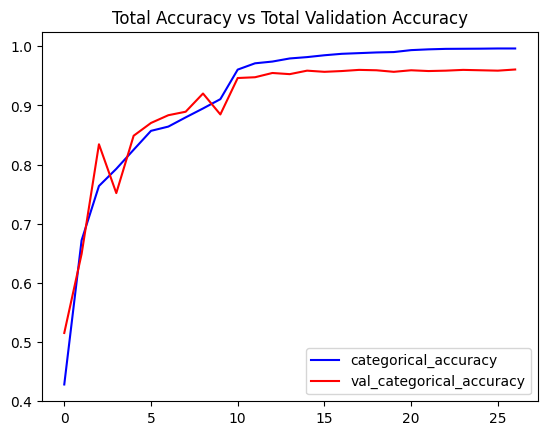

In [29]:
plot_metric(model_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

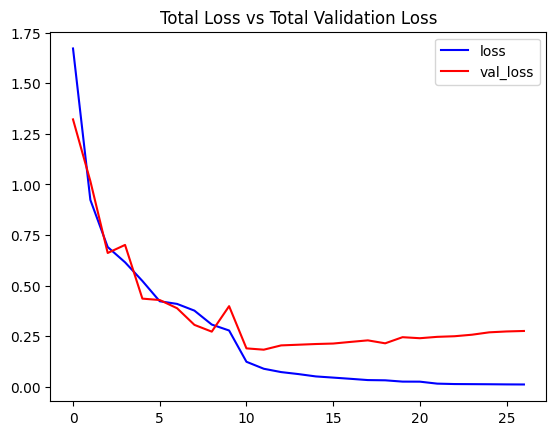

In [30]:
plot_metric(model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [31]:
model = tf.keras.models.load_model(path_weight)
yhat = model.predict(X_test)

60/60 [==============================] - 1s 9ms/step


In [32]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(y_true=ytrue, y_pred=yhat)


0.9564761405348715

<Axes: >

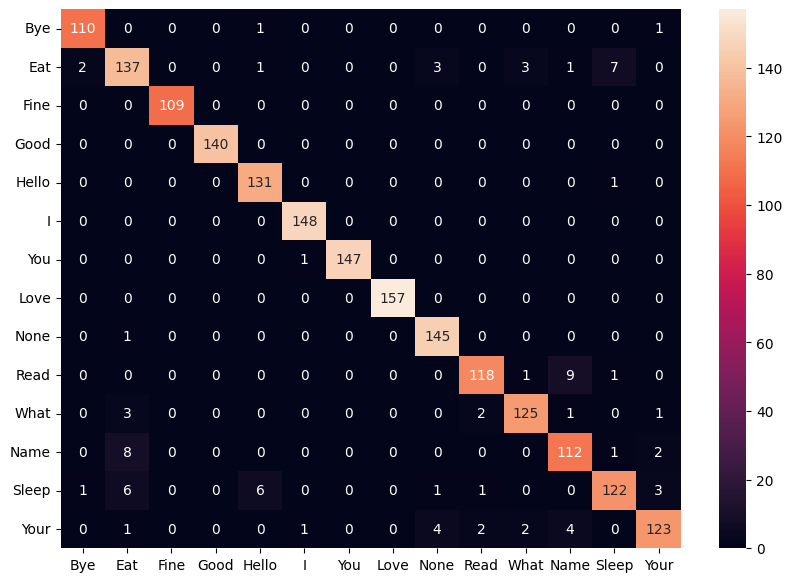

In [50]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
array = confusion_matrix(ytrue, yhat)
df_cm = pd.DataFrame(array, index = [i for i in actions],
                  columns = [i for i in actions])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')
# dự đoán là dọc